# DV2607 Project Notebook
### Authors:
### Oliver Ljung (ollj19@student.bth.se)
### Phoebe Waters (phaa19@student.bth.se)

## Importing modules and dataset

In [147]:
# imports
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Activation, BatchNormalization, LeakyReLU, Reshape, UpSampling2D, Dropout
from keras import Sequential, Model
from keras.datasets import mnist
from keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

import random

## Defining functions

In [148]:
# Defining functions

def create_generator():
    # Create a CNN model
    model = Sequential()

    model.add(Dense(7*7*28, activation='relu', input_dim=100))
    model.add(Reshape((7,7,28)))

    model.add(UpSampling2D())
    model.add(Conv2D(28, (3,3), activation='relu', padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())

    model.add(UpSampling2D())
    model.add(Conv2D(56, (3,3), activation='relu', padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())
    
    model.add(Conv2D(1, (3,3), activation='relu', padding="same"))
    model.add(Activation('tanh'))

    print(model.summary())

    input = Input(shape = (100))
    
    img = model(input)
    
    return Model(input, img)

def create_discriminator():
    # Create a CNN model
    model = Sequential()

    # Add Convolution layers
    model.add(Conv2D(28, (3,3), activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(56, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(56, (3,3), activation='relu'))

    model.add(Flatten())

    # Add predictive layers
    model.add(Dense(56, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())

    # Add input
    input = Input(shape = (28,28,1))

    # Get ouput from model
    validity = model(input)

    return Model(input, validity)

In [149]:
# load dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_X = train_X.astype("float32") / 255
test_X = test_X.astype("float32") / 255

train_X = np.expand_dims(train_X, -1)
test_X = np.expand_dims(test_X, -1)

train_y = to_categorical(train_y)
test_y  = to_categorical(test_y)

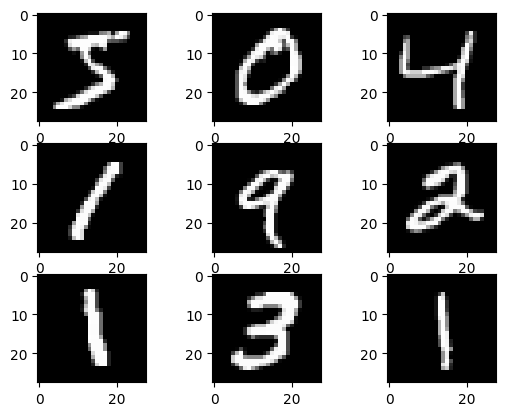

In [150]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
plt.show()

In [151]:
optimizer = tf.optimizers.Adam()

generator = create_generator()
input = Input(shape=(100,))
img_generated = generator(input)

# We want the generator and discriminator to be trained in a combined model but as seperate entities
discriminator = create_discriminator()
discriminator.compile(optimizer=optimizer, loss=["binary_crossentropy"], metrics=["accuracy"])
discriminator.trainable = False 
validity = discriminator(img_generated)

combined_model = Model(input, validity)
combined_model.compile(optimizer=optimizer, loss=["binary_crossentropy"], metrics=["accuracy"])

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 1372)              138572    
                                                                 
 reshape_11 (Reshape)        (None, 7, 7, 28)          0         
                                                                 
 up_sampling2d_31 (UpSamplin  (None, 14, 14, 28)       0         
 g2D)                                                            
                                                                 
 conv2d_79 (Conv2D)          (None, 14, 14, 28)        7084      
                                                                 
 batch_normalization_40 (Bat  (None, 14, 14, 28)       112       
 chNormalization)                                                
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 14, 14, 28)      

In [152]:
BATCH_SIZE = 32
EPOCHS = 5_000

y_real = np.ones((BATCH_SIZE, 1))
y_fake = np.zeros((BATCH_SIZE, 1))

for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch}")
    x_real = np.array(random.choices(train_X, k=BATCH_SIZE))
    
    seed = np.random.normal(0,1,(BATCH_SIZE, 100))
    x_fake = generator.predict(seed)

    discriminator.train_on_batch(x=x_real, y=y_real)
    discriminator.train_on_batch(x=x_fake, y=y_fake)
    combined_model.train_on_batch(x=seed, y=y_real)

generator.save("mnist_generator.h5")

EPOCH: 0
2/2 [==============================] - 1s 226ms/step
EPOCH: 1
2/2 [==============================] - 0s 212ms/step
EPOCH: 2
2/2 [==============================] - 0s 212ms/step
EPOCH: 3
2/2 [==============================] - 0s 203ms/step
EPOCH: 4
2/2 [==============================] - 0s 209ms/step
EPOCH: 5
2/2 [==============================] - 0s 202ms/step
EPOCH: 6
2/2 [==============================] - 0s 209ms/step
EPOCH: 7
2/2 [==============================] - 0s 201ms/step
EPOCH: 8
2/2 [==============================] - 0s 209ms/step
EPOCH: 9
2/2 [==============================] - 0s 206ms/step
EPOCH: 10
2/2 [==============================] - 0s 195ms/step
EPOCH: 11
2/2 [==============================] - 0s 204ms/step
EPOCH: 12
2/2 [==============================] - 0s 203ms/step
EPOCH: 13
2/2 [==============================] - 0s 246ms/step
EPOCH: 14
2/2 [==============================] - 0s 213ms/step
EPOCH: 15
2/2 [==============================] - 0s 189ms/step
EP

KeyboardInterrupt: 

1/1 [==============================] - 0s 354ms/step


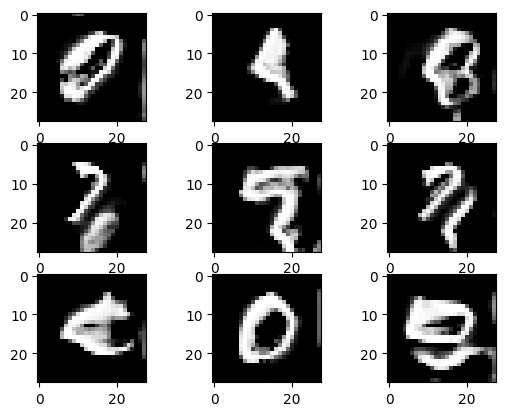

In [153]:
seed = np.random.normal(0,1,(9, 100))
x_fake = generator.predict(seed)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_fake[i], cmap=plt.get_cmap('gray'))
plt.show()